<a href="https://colab.research.google.com/github/lingyixu/CS523-Deep-Learning/blob/main/GCN_Multilabel_Classification_Confusion_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchmetrics

2.0.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.transforms import RandomNodeSplit
from torchmetrics.classification import BinaryHammingDistance

In [3]:
import pandas as pd
import numpy as np
import json
import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [4]:
import sys
is_colab = 'google.colab' in sys.modules

if is_colab:
    from google.colab import auth
    auth.authenticate_user()

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/CS523/lastFM-data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Artist Size Selection
asize = 600
likesize = 1028

In [8]:
df_feat = pd.read_json(drive_path + f'new_feature_{asize}_{likesize}.json')   # load features
arr_feat = df_feat.T.values
df_edge = pd.read_csv(drive_path + 'lastfm_asia_edges.csv')   # load edge indices
arr_edge = df_edge.T.values
df_tar = pd.read_csv(drive_path + 'lastfm_asia_target.csv', index_col=0)   # load targets
arr_tar = df_tar.values

num_nodes = arr_feat.shape[0]
num_features = arr_feat.shape[1]
num_classes = len(df_tar.target.unique())
classes = df_tar.target.sort_values().unique()

print('Dataset:')
print('====================')
print(f'Number of nodes: {num_nodes}')
print(f'Number of features: {num_features}')
print(f'Number of edges: {arr_edge.shape[1]}')
print(f'Number of distinct regions: {num_classes}')
print(f'All region classes: {classes}')

Dataset:
Number of nodes: 7624
Number of features: 600
Number of edges: 27806
Number of distinct regions: 18
All region classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [9]:
graph_metadata = {'data': arr_feat, 'edge_index': arr_edge, 'label': arr_tar}

In [10]:
class GraphDataset(Dataset):
    
    def __init__(self, root, out_dir, metadata, transform=None, pre_transform=None, pre_filter=None):
        self.root = root
        self.out_dir = out_dir
        self.metadata = metadata
        super(GraphDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return root

    @property
    def processed_file_names(self):
        return glob.glob(f'{self.out_dir}/*.pt')

    def download(self):
        pass
    
    
    def process(self):

        self.node_features = torch.tensor(self.metadata['data'], dtype=torch.float)
        self.edge_index = torch.tensor(self.metadata['edge_index'], dtype=torch.int64)
        self.label = torch.tensor(self.metadata['label'], dtype=torch.int64)
        # self.all_features = torch.concat([self.node_features, self.label], dim=1)   # take region as an additional feature
        
        data = Data(x = self.node_features,
                    edge_index = self.edge_index,
                    # edge_attr = None,
                    y = self.label)

        torch.save(data, f'{self.out_dir}/data.pt')

    def len(self):
        return self.node_features.shape[0]

    def get(self):
        data = torch.load(f'{self.out_dir}/data.pt')
        return data

In [11]:
root = ''
out_dir = 'graph_data'
os.mkdir(out_dir)
metadata = graph_metadata
dataset = GraphDataset(root=root, out_dir=out_dir, metadata=metadata)

Processing...
Done!


In [12]:
# inspect the graph dataset
data = dataset.get()
print()
print(data)
print('=============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')


Data(x=[7624, 600], edge_index=[2, 27806], y=[7624, 1])
Number of nodes: 7624
Number of edges: 27806


In [13]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

output = torch.load(f'/content/drive/Shareddrives/CS523/Notebooks/output/GCN_{asize}/all_folds.pt', map_location=torch.device('cpu'))

predict = output.detach().numpy()
actual = data.x.detach().numpy()
print(predict.shape)
print(actual.shape)
print(predict[0].round().shape)
print(len(actual))
#print(len(data.x.detach().numpy()))
#print(len(data.x.detach().numpy()[0]))

(7624, 600)
(7624, 600)
(600,)
7624


In [14]:
# Most True Positive User
best_user_tp = 0
best_user_id = 0
for i in range(len(predict)):
  best_user_confusion = metrics.confusion_matrix(actual[i], predict[i].round()) / len(predict[i])
  if ((best_user_confusion[1][1]+best_user_confusion[0][0]) > 0.75) and ((best_user_confusion[1][1] - best_user_confusion[0][1]) > 0.02):
    best_user_tp = best_user_confusion[1][1]+best_user_confusion[0][0]
    best_user_id = i
    print(best_user_id)
    #print(f'the best is: {best_user_id} with tp of {best_user_tp}')
print(f"Best True Positive User ID: {best_user_id}")
print(f"Best True Positive value: {best_user_tp}")


1000
1497
1873
2055
2918
3466
3905
4379
4801
4977
5006
5204
5940
6185
6221
6460
6856
7058
7065
7348
7390
Best True Positive User ID: 7390
Best True Positive value: 0.7633333333333334


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


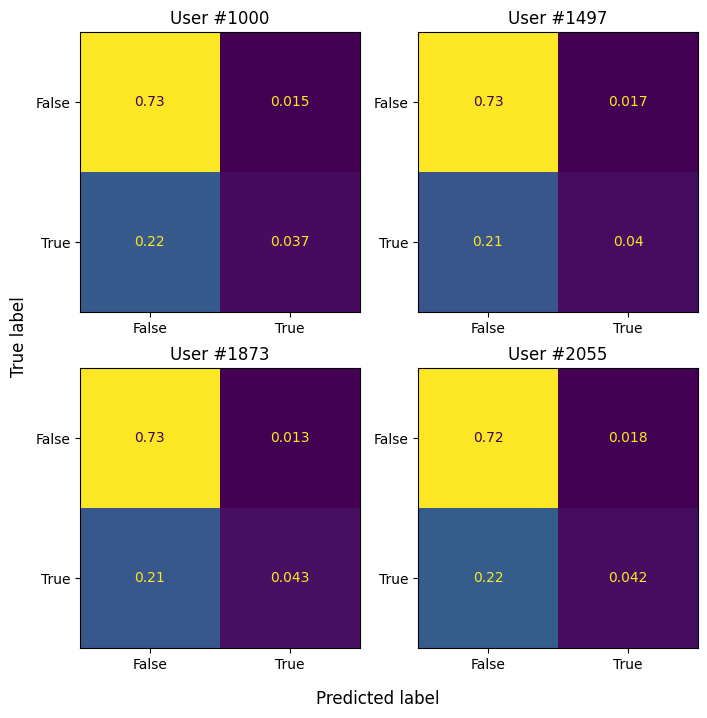

In [15]:
# Single User Confusion Matrix
user_id = 1000 # , 1497, 1873, 2055]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
a = np.array([[0.72,0.047], [0.21,0.029]])
single_user_confusion = metrics.confusion_matrix(actual[user_id], predict[user_id].round())
#print(single_user_confusion)
avg_single_user_confusion = single_user_confusion / len(predict[user_id])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = avg_single_user_confusion, display_labels = [False, True])
cm_display.plot(ax=axes[0][0])
cm_display.ax_.set_title(f'User #{user_id}')
cm_display.im_.colorbar.remove()
cm_display.ax_.set_xlabel('')
cm_display.ax_.set_ylabel('')
a = np.array([[0.75,0.045], [0.18,0.024]])
user_id = 1497
single_user_confusion = metrics.confusion_matrix(actual[user_id], predict[user_id].round())
#print(single_user_confusion)
avg_single_user_confusion = single_user_confusion / len(predict[user_id])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = avg_single_user_confusion, display_labels = [False, True])
cm_display.plot(ax=axes[0][1])
cm_display.ax_.set_title(f'User #{user_id}')
cm_display.im_.colorbar.remove()
cm_display.ax_.set_xlabel('')
if i!=0:
  cm_display.ax_.set_ylabel('')
a = np.array([[0.78,0.039], [0.17,0.019]])
user_id = 1873
single_user_confusion = metrics.confusion_matrix(actual[user_id], predict[user_id].round())
#print(single_user_confusion)
avg_single_user_confusion = single_user_confusion / len(predict[user_id])
print(type(avg_single_user_confusion))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = avg_single_user_confusion, display_labels = [False, True])
cm_display.plot(ax=axes[1][0])
cm_display.ax_.set_title(f'User #{user_id}')
cm_display.im_.colorbar.remove()
cm_display.ax_.set_xlabel('')
if i!=0:
  cm_display.ax_.set_ylabel('')
user_id = 2055
single_user_confusion = metrics.confusion_matrix(actual[user_id], predict[user_id].round())
#print(single_user_confusion)
avg_single_user_confusion = single_user_confusion / len(predict[user_id])
print(type(avg_single_user_confusion))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = avg_single_user_confusion, display_labels = [False, True])
cm_display.plot(ax=axes[1][1])
cm_display.ax_.set_title(f'User #{user_id}')
cm_display.im_.colorbar.remove()
cm_display.ax_.set_xlabel('')
if i!=0:
  cm_display.ax_.set_ylabel('')

fig.text(0.5, 0.04, 'Predicted label', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'True label', va='center', rotation='vertical', fontsize=12)

#plt.tight_layout()
#plt.xlabel('Predicted label')
#plt.ylabel('True label')

plt.show()




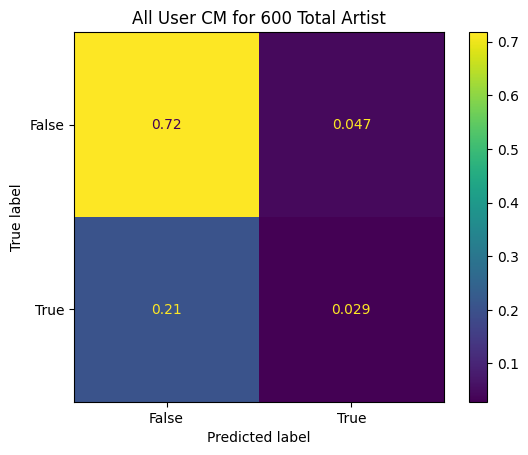

In [16]:
# All User Average Confusion Matrix
total_user_confusion = metrics.confusion_matrix(actual[0], predict[0].round())
for i in range(1, len(predict)):
  total_user_confusion += metrics.confusion_matrix(actual[i], predict[i].round())
avg_total_user_confusion = total_user_confusion / len(predict) / len(predict[0])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = avg_total_user_confusion, display_labels = [False, True])
cm_display.plot()
plt.title(f'All User CM for {asize} Total Artist')
plt.show()

In [17]:
import pandas as pd

df = pd.read_csv(r'/content/drive/Shareddrives/CS523/lastFM-data/lastfm_asia_target.csv')
print(f'The heading of region target list: \n{df}')
region_target = df.to_numpy()
print(f'The shape of the region target list: {region_target.shape}')
myDict = {}
for i in range(18):
  temp = region_target[region_target[:, 1] == i, 0]
  myDict[f'{i}'] = temp
k = 5
print(f"The {i}th region {k}th user is: {myDict[f'{i}'][k]}")
print(len(myDict))

The heading of region target list: 
        id  target
0        0       8
1        1      17
2        2       3
3        3      17
4        4       5
...    ...     ...
7619  7619      10
7620  7620      10
7621  7621       0
7622  7622      17
7623  7623      11

[7624 rows x 2 columns]
The shape of the region target list: (7624, 2)
The 17th region 5th user is: 14
18


In [18]:
# Regional CM Generator
def region_user_cm(actual, predict, myDict, select_region):
  region_user_confusion = metrics.confusion_matrix(actual[myDict[f'{select_region}'][0]], predict[myDict[f'{select_region}'][0]].round())
  for i in range(1, len(myDict[f'{select_region}'])):
    region_user_confusion += metrics.confusion_matrix(actual[myDict[f'{select_region}'][i]], predict[myDict[f'{select_region}'][i]].round())
  avg_region_user_confusion = region_user_confusion / len(myDict[f'{select_region}']) / len(predict[0])
  return region_user_confusion, avg_region_user_confusion

In [19]:
# Most True Positive Region
best_total_region_confusion, best_avg_region_confusion = region_user_cm(actual, predict, myDict, 0)
best_total_region_tp = best_total_region_confusion[1][1]
best_total_region_id = 0
best_avg_region_tp = best_avg_region_confusion[1][1]
best_avg_region_id = 0

for i in range(1, len(myDict)):
  temp_total_region_confusion, temp_avg_region_confusion = region_user_cm(actual, predict, myDict, i)
  #print(f'{temp_avg_region_confusion[1][1]}, {best_avg_region_confusion[1][1]}')
  if temp_total_region_confusion[1][1] > best_total_region_confusion[1][1]:
    best_total_region_tp = temp_total_region_confusion[1][1]
    best_total_region_id = i
    best_total_region_confusion = temp_total_region_confusion
  if temp_avg_region_confusion[1][1] > best_avg_region_confusion[1][1]:
    best_avg_region_tp = temp_avg_region_confusion[1][1]
    best_avg_region_id = i
    best_avg_region_confusion = temp_avg_region_confusion
print(f"Best total True Positive Region ID: {best_total_region_id}")
print(f"Best total True Positive Region value: {best_total_region_tp}")
print(f"Best avg True Positive Region ID: {best_avg_region_id}")
print(f"Best avg True Positive Region value: {best_avg_region_tp}")

Best total True Positive Region ID: 10
Best total True Positive Region value: 23696
Best avg True Positive Region ID: 0
Best avg True Positive Region value: 0.033571645415907715


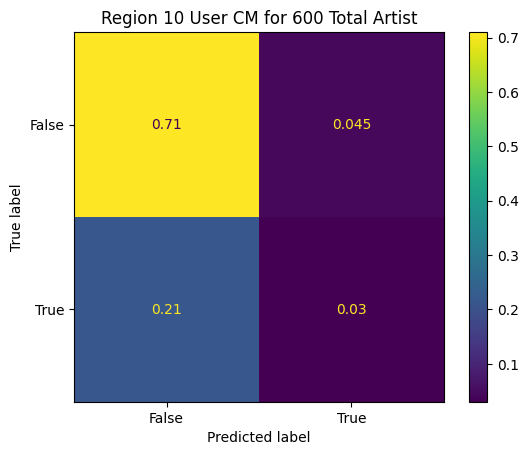

In [20]:
# Regional User Average Confusion Matrix
select_region = 10
_, avg_region_user_confusion = region_user_cm(actual, predict, myDict, select_region)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = avg_region_user_confusion, display_labels = [False, True])
cm_display.plot()
plt.title(f'Region {select_region} User CM for {asize} Total Artist')
plt.show()

In [21]:
artist_pre_info = {}
artist_act_info = {}
for i in range(len(predict[0])):
  artist_pre = []
  artist_act = []
  for j in range(len(predict)):
    artist_pre.append(predict[j][i].round())
    artist_act.append(actual[j][i])
  artist_pre_info[i] = artist_pre
  artist_act_info[i] = artist_act



In [22]:
print(artist_act_info[0])
print(artist_pre_info[0])
print(len(artist_act_info))

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0,

7624


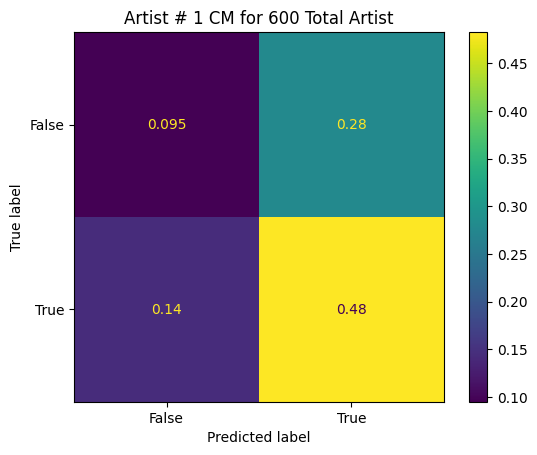

In [23]:
# Single Artist Confusion Matrix
artist_id = 1
print(len(predict))
single_artist_confusion = metrics.confusion_matrix(artist_act_info[artist_id], artist_pre_info[artist_id])
avg_single_artist_confusion = single_artist_confusion/len(predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = avg_single_artist_confusion, display_labels = [False, True])
cm_display.plot()
plt.title(f'Artist # {artist_id} CM for {asize} Total Artist')
plt.show()

In [24]:
# Top Artist Checker
top_number = 10
artist_likes_act = []

for i in range(0, arr_feat.shape[1]):
  artist_likes_act.append(sum(arr_feat[:,i]))
top_artist_index = np.argsort(artist_likes_act)[-top_number:]
for i in range(top_number):
  print("Artist #" + str(top_artist_index[i]) + " has " + str(artist_likes_act[top_artist_index[i]]) + " likes")

Artist #9 has 3901 likes
Artist #8 has 3988 likes
Artist #7 has 4055 likes
Artist #6 has 4154 likes
Artist #5 has 4181 likes
Artist #4 has 4224 likes
Artist #3 has 4398 likes
Artist #2 has 4429 likes
Artist #1 has 4777 likes
Artist #0 has 5532 likes


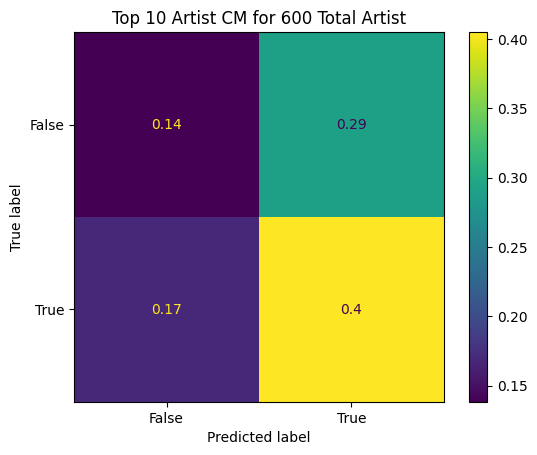

In [25]:
# Top Artist Average Confusion Matrix
top_artist_confusion = metrics.confusion_matrix(artist_act_info[0], artist_pre_info[0])
for i in range(1, top_number):
  top_artist_confusion += metrics.confusion_matrix(artist_act_info[i], artist_pre_info[i])
avg_top_artist_confusion = top_artist_confusion / len(predict) / top_number
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = avg_top_artist_confusion, display_labels = [False, True])
cm_display.plot()
plt.title(f'Top {top_number} Artist CM for {asize} Total Artist')
plt.show()

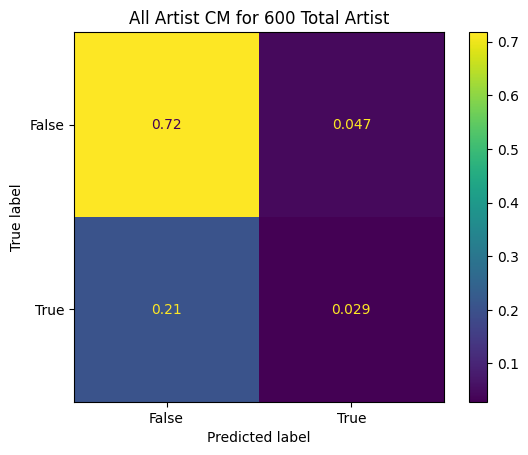

In [26]:
# Total Artist Average Confusion Matrix
total_artist_confusion = metrics.confusion_matrix(artist_act_info[0], artist_pre_info[0])
for i in range(1, len(artist_pre_info)):
  total_artist_confusion += metrics.confusion_matrix(artist_act_info[i], artist_pre_info[i])
avg_total_artist_confusion = total_artist_confusion / len(predict) / len(artist_pre_info)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = avg_total_artist_confusion, display_labels = [False, True])
cm_display.plot()
plt.title(f'All Artist CM for {asize} Total Artist')
plt.show()